In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

In [2]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, isnan, when, count, isnull

In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
%time
spark = SparkSession.builder \
    .appName("Flight Data Analysis") \
    .getOrCreate()

spark.conf.set("spark.sql.debug.maxToStringFields", 1000)
spark.sparkContext.setLogLevel("ERROR")

CPU times: total: 0 ns
Wall time: 9.54 μs


In [5]:
%time
import glob
import os
os.getcwd()
# home_dir = os.path.expanduser('~')
# folder_path = os.path.join(home_dir, 'Desktop/GroupProject/data/archive/raw')
# folder_path = '~/Desktop/GroupProject/data/archive/raw'
folder_path = 'C:/lecture-notebooks/GroupProject/data/archive/raw'
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
df = spark.read.csv(csv_files,
                       sep = ',',
                       inferSchema = True,
                       header = True)


CPU times: total: 0 ns
Wall time: 3.81 μs


In [6]:
num_entries = df.count()
num_entries

29193782

### Ahyo's work

In [7]:
null_counts = df.select([count(col(c)).alias(c) for c in df.columns]).collect()[0].asDict()
print(null_counts)

{'Year': 29193782, 'Quarter': 29193782, 'Month': 29193782, 'DayofMonth': 29193782, 'DayOfWeek': 29193782, 'FlightDate': 29193782, 'Marketing_Airline_Network': 29193782, 'Operated_or_Branded_Code_Share_Partners': 29193782, 'DOT_ID_Marketing_Airline': 29193782, 'IATA_Code_Marketing_Airline': 29193782, 'Flight_Number_Marketing_Airline': 29193782, 'Originally_Scheduled_Code_Share_Airline': 3873, 'DOT_ID_Originally_Scheduled_Code_Share_Airline': 3873, 'IATA_Code_Originally_Scheduled_Code_Share_Airline': 3873, 'Flight_Num_Originally_Scheduled_Code_Share_Airline': 3873, 'Operating_Airline ': 29193782, 'DOT_ID_Operating_Airline': 29193782, 'IATA_Code_Operating_Airline': 29193782, 'Tail_Number': 28926171, 'Flight_Number_Operating_Airline': 29193782, 'OriginAirportID': 29193782, 'OriginAirportSeqID': 29193782, 'OriginCityMarketID': 29193782, 'Origin': 29193782, 'OriginCityName': 29193782, 'OriginState': 29193782, 'OriginStateFips': 29193782, 'OriginStateName': 29193782, 'OriginWac': 29193782, 'D

In [8]:
columns_with_few_nulls = [col_name for col_name, count_val in null_counts.items() if count_val > 0.9*num_entries]
#columns_with_no_nulls = [col_name for col_name, count_val in null_counts.items() if count_val != 0]
print(columns_with_few_nulls)
#print(columns_with_all_nulls)
#df.select(*columns_with_nulls).show()

['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners', 'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline', 'Flight_Number_Marketing_Airline', 'Operating_Airline ', 'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline', 'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'Origin', 'OriginCityName', 'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'Dest', 'DestCityName', 'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'CRSDepTime', 'DepTime', 'DepDelay', 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrTime', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 'ArrTimeBlk', 'Cancelled', 'Diverted', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'Fligh

In [9]:
len(columns_with_few_nulls)

62

# Nam's work

The following columns were manually chosen after reading column description on Kaggle.

In [10]:
cols_to_check = ['Marketing_Airline_Network', 'Operating_Airline ', 'Origin', 'Dest', 'DepDel15', 'DepDelay', 'ArrDel15', 'ArrDelay',\
                 'Cancelled', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',\
                 'Distance', 'Year', 'Month', 'DayofMonth', 'FlightDate', 'Flight_Number_Operating_Airline']
print(f'col_to_check = {len(cols_to_check)}')
# Check to see if interested columns is in columns_with_few_nulls
removed_col = []
my_cols = []
for c in cols_to_check:
    if c in columns_with_few_nulls:
        my_cols.append(c)
    else:
        removed_col.append(c)

print(len(my_cols))

col_to_check = 20
15


In [11]:
print('Chosen columns')
my_cols

Chosen columns


['Marketing_Airline_Network',
 'Operating_Airline ',
 'Origin',
 'Dest',
 'DepDel15',
 'DepDelay',
 'ArrDel15',
 'ArrDelay',
 'Cancelled',
 'Distance',
 'Year',
 'Month',
 'DayofMonth',
 'FlightDate',
 'Flight_Number_Operating_Airline']

In [12]:
print('Columns with too many nulls')
removed_col

Columns with too many nulls


['CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay']

In [13]:
my_df = df.select(my_cols)
my_df.printSchema()

root
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operating_Airline : string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DepDel15: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrDel15: double (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- Cancelled: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- FlightDate: date (nullable = true)
 |-- Flight_Number_Operating_Airline: integer (nullable = true)



In [14]:
# Check number of nulls for each column and their respective percentage
print(f'Total number of entries: {num_entries}')
print('number of nulls and percentage in interested columns:')
col_with_nulls = []
for c in my_cols:
    num_null = num_entries - null_counts[c]
    print(f'{c}: {num_null} ({num_null / num_entries * 100}%)')
    col_with_nulls.append(c)

Total number of entries: 29193782
number of nulls and percentage in interested columns:
Marketing_Airline_Network: 0 (0.0%)
Operating_Airline : 0 (0.0%)
Origin: 0 (0.0%)
Dest: 0 (0.0%)
DepDel15: 763084 (2.6138579783873155%)
DepDelay: 763084 (2.6138579783873155%)
ArrDel15: 846183 (2.898504208875712%)
ArrDelay: 846183 (2.898504208875712%)
Cancelled: 0 (0.0%)
Distance: 0 (0.0%)
Year: 0 (0.0%)
Month: 0 (0.0%)
DayofMonth: 0 (0.0%)
FlightDate: 0 (0.0%)
Flight_Number_Operating_Airline: 0 (0.0%)


Null values account for only a few entries in our dataset (< 3%). But it might not be a straightforward idea to simply do a dropna()

In [15]:
columns_to_check = ['DepDel15', 'DepDelay', 'ArrDel15', 'ArrDelay']
print('There are entries where Cancelled column will have value of 1 (canceled) while other columns might be null')
for c in columns_to_check:
    num_to_display = my_df.where(isnull(col(c)) & (col('Cancelled') == 1)).count()
    print(f'Number of entries where {c} column is null but Cancelled is 1: {num_to_display}')

There are entries where Cancelled column will have value of 1 (canceled) while other columns might be null
Number of entries where DepDel15 column is null but Cancelled is 1: 761971
Number of entries where DepDelay column is null but Cancelled is 1: 761971
Number of entries where ArrDel15 column is null but Cancelled is 1: 777267
Number of entries where ArrDelay column is null but Cancelled is 1: 777267


Since I intend to do data exploration with cancelled flights, it is not a good idea for me to do dropna() on the dataset as I will lose data for those flights.

In [16]:
# This cell was originally intended to drop all rows with null. But it has been commented out to preserve data for cancelled flights


# my_df = my_df.dropna()
# entries_count = my_df.count()
# print(f'Number of entries after dropping nulls: {entries_count}')
# print(f'Percentage of rows dropped: {(1 - entries_count/num_entries) * 100}%')

In [17]:
# I was attempting to do histogram for different columns. But I encountered "Python worker failed to connect." error


# hist = my_df.select(col('DepDelay')).rdd.flatMap(lambda x: x).histogram(20)

In [18]:
num_delayed = my_df.where(col('DepDel15') == 1).count()
num_cancelled = my_df.where(col('Cancelled') == 1).count()
print(f'Number of flights that were delayed by more than 15 minutes: {num_delayed}')
print(f'Number of flights that were cancelled: {num_cancelled}')

Number of flights that were delayed by more than 15 minutes: 4911896
Number of flights that were cancelled: 777267


#### Delayed flights and cancelled flights by operating airlines

##### Delayed flights by airlines

In [19]:
# aggregate by operating airline and turn into Pandas dataframe
airline_flights = my_df.groupBy(col('Operating_Airline ')).agg(F.sum(col('DepDel15')).alias('DelayedFlights'),
                                                               F.sum(col('Cancelled')).alias('CancelledFlights'),
                                                               F.count('*').alias('TotalFlights'))
airline_flights_pd = airline_flights.toPandas()
airline_flights_pd['DelayedPercentage'] = airline_flights_pd['DelayedFlights'] / airline_flights_pd['TotalFlights']
airline_flights_pd['CancelledPercentage'] = airline_flights_pd['CancelledFlights'] / airline_flights_pd['TotalFlights']
airline_flights_pd

,Operating_Airline,DelayedFlights,CancelledFlights,TotalFlights,DelayedPercentage,CancelledPercentage
0,UA,401781.0,47061.0,2354538,0.170641,0.019987
1,NK,150479.0,18150.0,836694,0.179850,0.021693
2,EV,62030.0,14363.0,353669,0.175390,0.040611
3,B6,275829.0,29095.0,1106079,0.249375,0.026305
4,DL,421087.0,46734.0,3294917,0.127799,0.014184
5,9K,132.0,2.0,1661,0.079470,0.001204
6,OO,460853.0,72587.0,3159683,0.145854,0.022973
7,F9,134532.0,13730.0,570452,0.235834,0.024069
8,YV,125633.0,25769.0,749216,0.167686,0.034395
9,C5,58345.0,11005.0,260048,0.224362,0.042319


Text(0, 0.5, '')

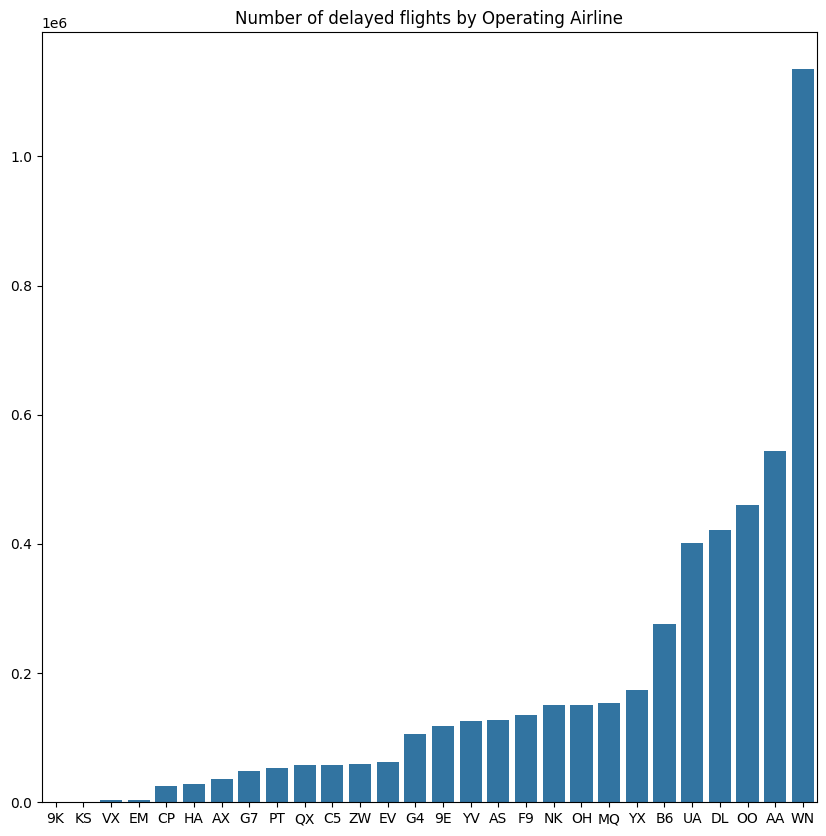

In [20]:
airline_flights_pd = airline_flights_pd.sort_values(by = 'DelayedFlights', axis = 0, ascending = True)
fig, ax = plt.subplots(figsize=(10, 10))
percentage_barplot = sns.barplot(data = airline_flights_pd, x = 'Operating_Airline ', y = 'DelayedFlights')
plt.title('Number of delayed flights by Operating Airline')
plt.xlabel('')
plt.ylabel('')

Text(0, 0.5, '')

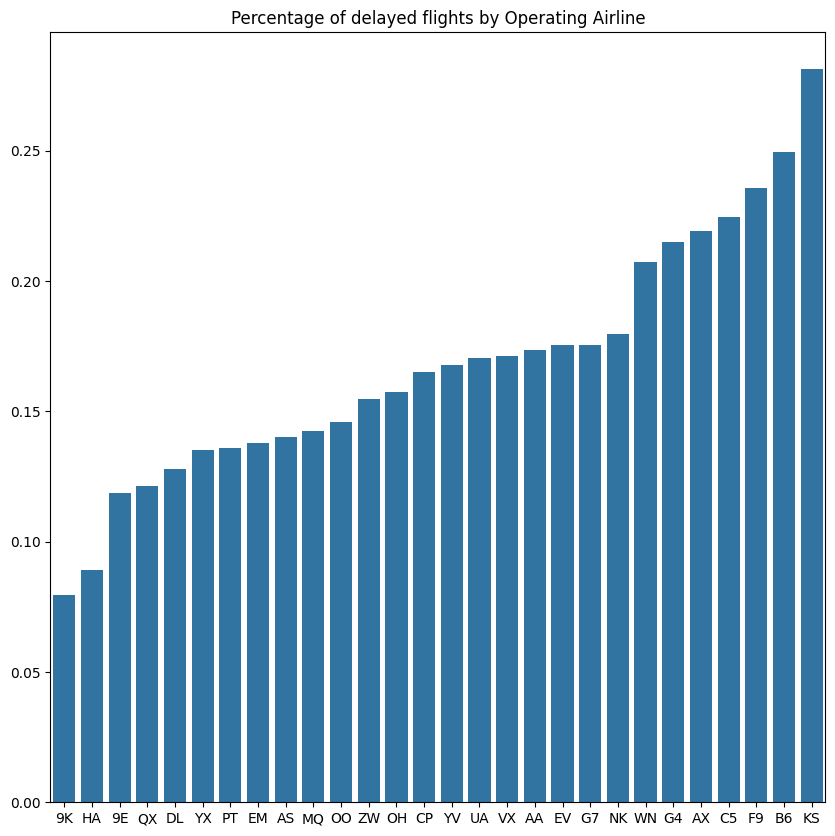

In [21]:
airline_flights_pd = airline_flights_pd.sort_values(by = 'DelayedPercentage', axis = 0, ascending = True)
fig, ax = plt.subplots(figsize=(10, 10))
percentage_barplot = sns.barplot(data = airline_flights_pd, x = 'Operating_Airline ', y = 'DelayedPercentage')
plt.title('Percentage of delayed flights by Operating Airline')
plt.xlabel('')
plt.ylabel('')

The majority of airlines have about 10 - 25% of their flights delayed.

##### Cancelled flights by airlines

Text(0, 0.5, '')

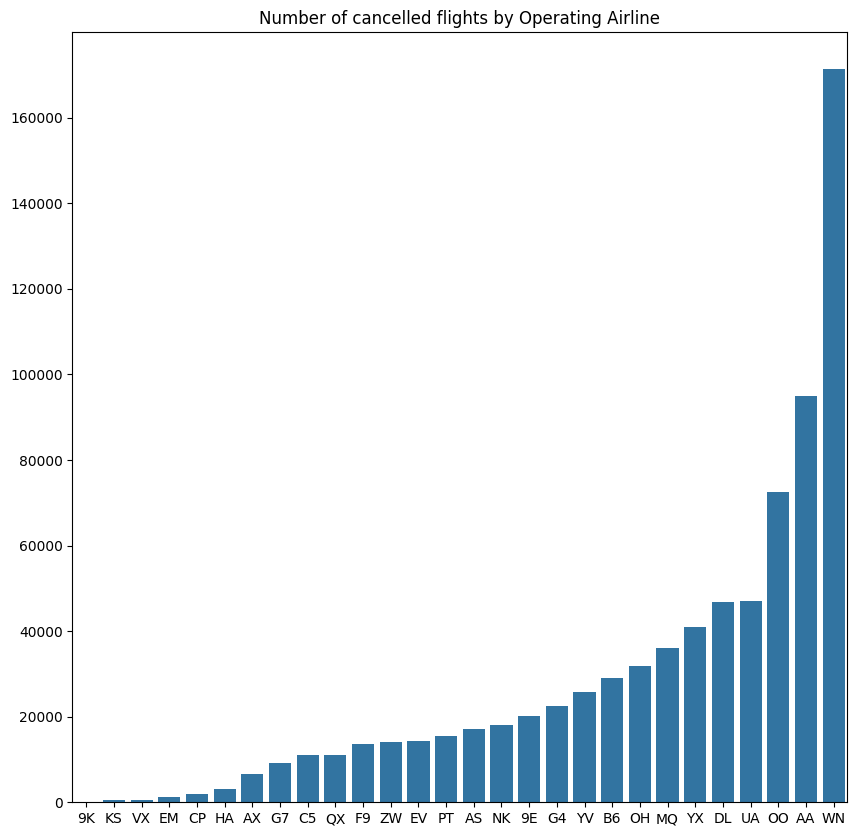

In [22]:
airline_flights_pd = airline_flights_pd.sort_values(by = 'CancelledFlights', axis = 0, ascending = True)
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(data = airline_flights_pd, x = 'Operating_Airline ', y = 'CancelledFlights')
plt.title('Number of cancelled flights by Operating Airline')
plt.xlabel('')
plt.ylabel('')

Text(0, 0.5, '')

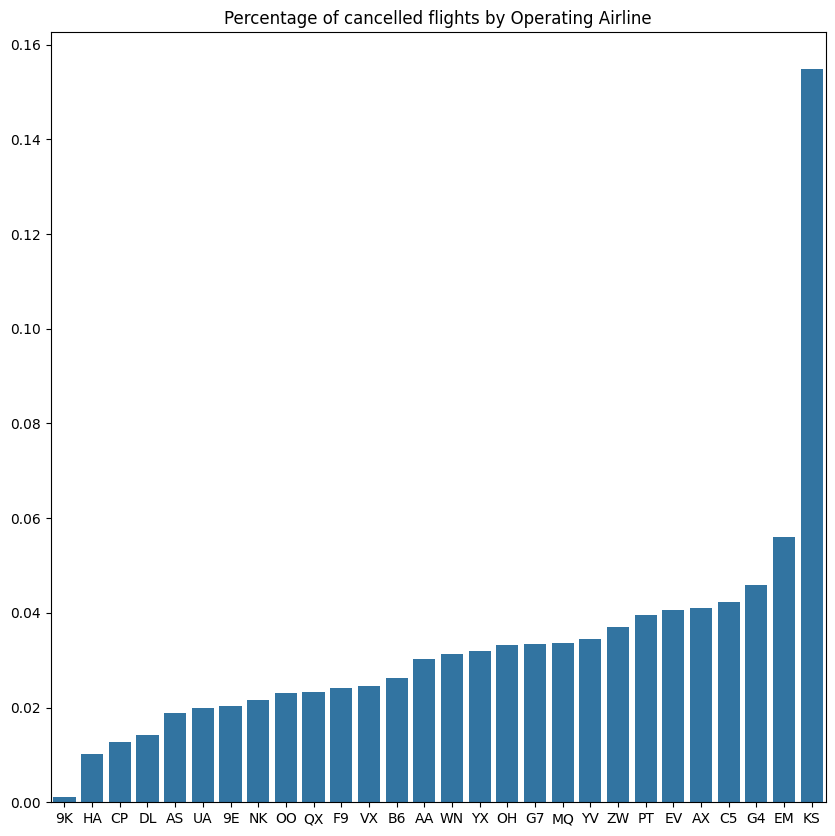

In [23]:
airline_flights_pd = airline_flights_pd.sort_values(by = 'CancelledPercentage', axis = 0, ascending = True)
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(data = airline_flights_pd, x = 'Operating_Airline ', y = 'CancelledPercentage')
plt.title('Percentage of cancelled flights by Operating Airline')
plt.xlabel('')
plt.ylabel('')

Most airlines cancel less than 5% of their total flights.

#### Delayed flights and cancelled flights aggregated by time

In [24]:
time_agg = my_df.groupBy('Year', 'Month').agg(F.sum(col('DepDel15')).alias('DelayedFlights'),
                                              F.sum(col('Cancelled')).alias('CancelledFlights'),
                                              F.count('*').alias('TotalFlights'))
time_agg_pd = time_agg.toPandas()
time_agg_pd['DelayedPercentage'] = time_agg_pd['DelayedFlights'] / time_agg_pd['TotalFlights']
time_agg_pd['CancelledPercentage'] = time_agg_pd['CancelledFlights'] / time_agg_pd['TotalFlights']
time_agg_pd.head(10)

,Year,Month,DelayedFlights,CancelledFlights,TotalFlights,DelayedPercentage,CancelledPercentage
0,2018,1,80577.0,12690.0,457688,0.176052,0.027726
1,2018,10,102412.0,5202.0,670090,0.152833,0.007763
2,2018,11,114320.0,7769.0,638985,0.178909,0.012158
3,2018,12,115105.0,7803.0,649325,0.177269,0.012017
4,2018,3,61801.0,8939.0,346132,0.178547,0.025825
5,2018,4,83925.0,4778.0,482983,0.173764,0.009893
6,2018,5,73532.0,4350.0,350044,0.210065,0.012427
7,2018,6,73360.0,4306.0,317713,0.230900,0.013553
8,2018,7,82432.0,6215.0,367221,0.224475,0.016924
9,2018,8,113887.0,11669.0,503612,0.226140,0.023171


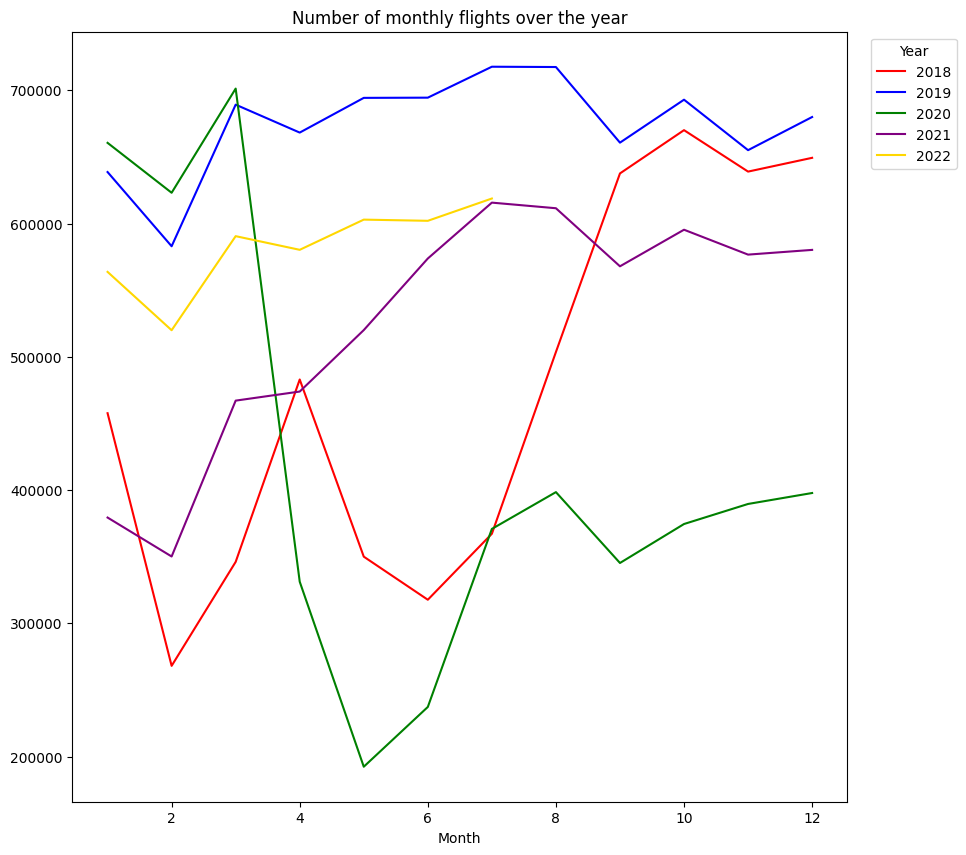

In [25]:
colors = ['red', 'blue', 'green', 'purple', 'gold']
fig, ax = plt.subplots(figsize=(10, 10))
barplot = sns.lineplot(data = time_agg_pd, x = 'Month', y = 'TotalFlights', hue = 'Year', palette = colors)
plt.title('Number of monthly flights over the year')
plt.ylabel('')
plt.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1), title = 'Year')

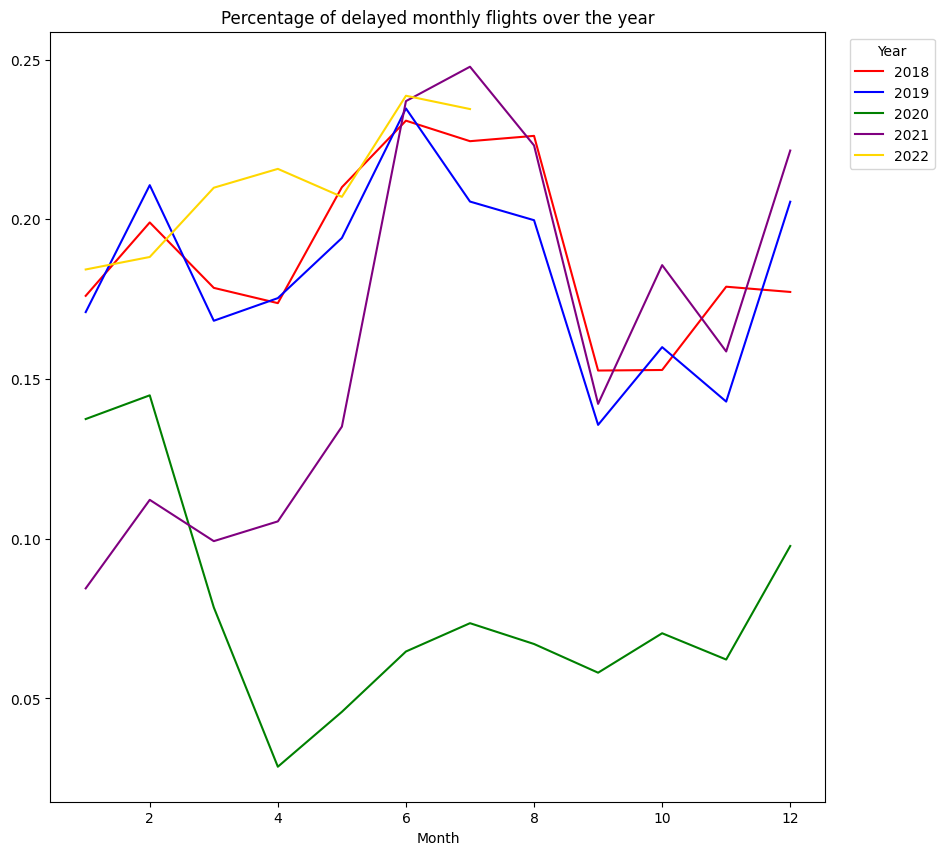

In [26]:
colors = ['red', 'blue', 'green', 'purple', 'gold']
fig, ax = plt.subplots(figsize=(10, 10))
barplot = sns.lineplot(data = time_agg_pd, x = 'Month', y = 'DelayedPercentage', hue = 'Year', palette = colors)
plt.title('Percentage of delayed monthly flights over the year')
plt.ylabel('')
plt.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1), title = 'Year')

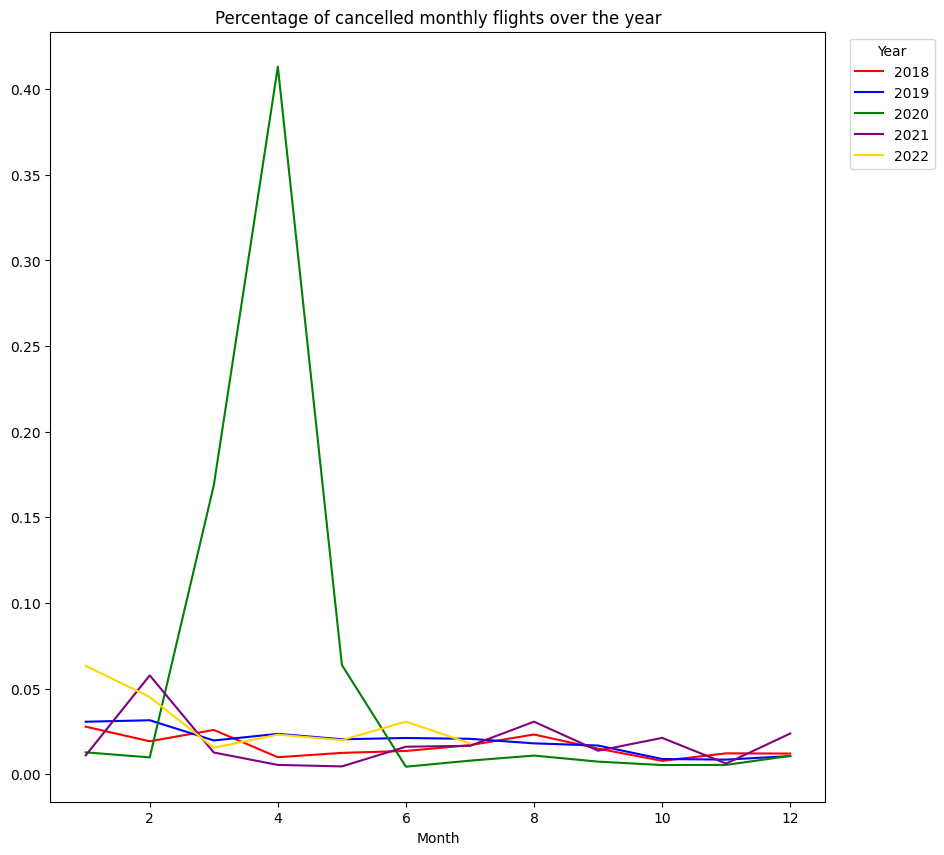

In [27]:
colors = ['red', 'blue', 'green', 'purple', 'gold']
fig, ax = plt.subplots(figsize=(10, 10))
barplot = sns.lineplot(data = time_agg_pd, x = 'Month', y = 'CancelledPercentage', hue = 'Year', palette = colors)
plt.title('Percentage of cancelled monthly flights over the year')
plt.ylabel('')
plt.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1), title = 'Year')

# Conclusion

##### Data cleaning

Thanks to Ahyo's work, we can learn that the majority of columns in our dataset contains a large number of NaN. We are able to quickly filter out those columns and focus on the others.

My analysis focused on delayed and cancelled flights. I learned that entries of cancelled flights will have nulls in other columns making a simple dropna() not a viable data cleaning method.

If we are to work with cancelled flights, we have to find away to fill in the nulls of other columns.

##### Aggregated by operating airlines

Despite how miserable air travelling is, flights are seldomly late. About 10 - 25% of flights are at least 15 minutes late to depart. From the graph, I would say that an average of 15% of flights operated by any airlines are late to depart.

Airlines are keen to keep their flights operational cancelling less than 5% of their total scheduled flights. This makes sense as cancellation results in not only loss of revenue but also compensation of damages and potential loss of opportunities.

Airline denoted by KS (Peninsula Airways) stood out to me. They do not serve a lot of flights. But their delayed and cancelled metrics are area of improvement to say the least.

##### Aggregated by time

Acknowledgement: I understand that the airline industry was heavy affected by COVID-19 and that the industry is recovering to pre-pandemic numbers.

Overall, it seems that February tends to be a slow month for the airline industry. The summer months are busy. The holiday months of September - December are only slight less busy than the summer months. People are more likely to travel in the second half of the year.

The data for 2018 flights stood out to me. The year started with fewer flights than 2021 and 2022 (post COVID-19 years) but then suddenly gained 300,000 flights for the summer months. This indicates to me that there is a potential socio/economical/geopolitical event happening or and issue with data collection.

Delayed flights are likely to happen during peak of the traveling seasons contributing to the misery of air travelling. February is an interesting month as customers are not travelling but flights pick up an increase in chance of being delayed. My guess is that flight crews and ground crews are burned out from the holiday season and their performance is decreased.

As for cancelled flights, there is a gigantic mountain that sits in the middle of the graph. Almost half of scheduled flights for April of 2020 are cancelled. I wonder what happened.